### Assignment 2: Detecting Linux system hacking activities<br>

Name: Manmeet Singh<br>
ID: 30749476


#### 1.1 Creating Spark Session

In [1]:
# Import SparkConf, RDD, SparkContext, SparkSession class into program
from pyspark import SparkConf
from pyspark.rdd import RDD
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
import numpy as np
import csv

# Using all the processor 
master = "local[*]"
# Initiallizing app name
app_name = "Ass 2"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# instantiating a SparkContext
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [2]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import isnan, when, count, col

#### 1.2 Loading the data

In [67]:
df_memory = spark.read.format('csv')\
            .option('header',True).option('escape','"').option('inferSchema', True)\
            .load('*memory*.csv').repartition(4)
df_process = spark.read.format('csv')\
            .option('header',True).option('escape','"').option('inferSchema', True)\
            .load('*process*.csv').repartition(4)

In [4]:
# cache the data for faster processing
df_memory = df_memory.cache()
df_process = df_process.cache()

In [68]:
# number of partition in each data frame
df_memory.rdd.getNumPartitions()
df_process.rdd.getNumPartitions()

4

In [6]:
# counting rows
print("Process data count", df_process.count())
print("Memory data count", df_memory.count())

Process data count 1927968
Memory data count 2000000


In [7]:
# checking if any null values
print("Process data\n")
df_process.select([count(when(isnan(c), c)).alias(c) for c in df_process.columns]).show()
print("Memory data\n")
df_memory.select([count(when(isnan(c), c)).alias(c) for c in df_memory.columns]).show()

Process data

+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
| ts|PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|CMD|attack|type|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
|  0|  0|   0|    0|    0|   0|   0|  0|   0|    0|     0|  0|    0|  0|  0|     0|   0|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+

Memory data

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



In [8]:
# data type conversion and Process data Schema
df_process = df_process.withColumn('CPU', F.col('CPU').cast('int'))
df_process.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: integer (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)



In [9]:
# memory data schema
df_memory.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: string (nullable = true)
 |-- MAJFLT: string (nullable = true)
 |-- VSTEXT: string (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: string (nullable = true)
 |-- VGROW: string (nullable = true)
 |-- RGROW: string (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)



In [10]:
# removing K, and M from data and converting data type
from pyspark.sql.functions import substring,length
colList = ['MINFLT', 'MAJFLT', 'VSTEXT', 'RSIZE', 'VGROW', 'RGROW']

for column in colList:
    # trim space from numeric data
    df_memory = df_memory.withColumn(column, F.trim(F.col(column)))
    string = 'substring({0},1,length({0})-1)'.format(column)
    # remove K from numeric data and multiply with 1000
    df_memory = df_memory.withColumn(column,\
    F.when(F.col(column).contains('K'),F.expr(string).cast('int')*1000).otherwise(F.col(column).cast('int')))
    # remove M from numeric data and multiply with 1000000
    df_memory = df_memory.withColumn(column,\
    F.when(F.col(column).contains('M'),F.expr(string).cast('int')*1000000).otherwise(F.col(column).cast('int')))

In [11]:
# data conversion
df_memory = df_memory.withColumn('VSIZE', F.col('VSIZE').cast('int'))
df_memory = df_memory.withColumn('MEM', F.col('MEM').cast('int'))
df_memory.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: integer (nullable = true)
 |-- MAJFLT: integer (nullable = true)
 |-- VSTEXT: integer (nullable = true)
 |-- VSIZE: integer (nullable = true)
 |-- RSIZE: integer (nullable = true)
 |-- VGROW: integer (nullable = true)
 |-- RGROW: integer (nullable = true)
 |-- MEM: integer (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)



In [12]:
# checking again for null values
df_memory.select([count(when(isnan(c), c)).alias(c) for c in df_memory.columns]).show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



#### 1.3 Exploring the data

In [13]:
# taking count of label attack for memory data
df_memory.groupBy('attack').count().show()

+------+-------+
|attack|  count|
+------+-------+
|     1| 205623|
|     0|1794377|
+------+-------+



In [14]:
# taking count of label attack for process data
df_process.groupBy('attack').count().show()

+------+-------+
|attack|  count|
+------+-------+
|     1| 291364|
|     0|1636604|
+------+-------+



In [15]:
# Count of type w.r.t attack label for memory
df_memory.groupBy('type').agg(F.count('attack')).show()

+---------+-------------+
|     type|count(attack)|
+---------+-------------+
| password|        26016|
|     ddos|        45689|
|   normal|      1794377|
|     mitm|          112|
|injection|        58523|
|      dos|        75283|
+---------+-------------+



In [16]:
# Count of type w.r.t attack label for process
df_process.groupBy('type').agg(F.count('attack')).show()

+---------+-------------+
|     type|count(attack)|
+---------+-------------+
|      xss|        17759|
| password|        51409|
| scanning|        38449|
|     ddos|        71603|
|   normal|      1636604|
|     mitm|          112|
|injection|        41311|
|      dos|        70721|
+---------+-------------+



**Do you see any class imbalance?** <br>
We can see class imbalance in both Process and Memory data. Both data have more non attack value that is 0, 1.7 million and 1.6 million for memory and process data respectively. On the other hand attack class 1 has data around 205K and 291K for memory and process data respectively.

In [17]:
# getting numeric columns and their stats for memory data
numeric_features_memory = [x[0] for x in df_memory.dtypes if x[1] == 'int']
numeric_features_memory.remove('attack')
df_memory.select(numeric_features_memory).describe().toPandas()

,summary,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM
0,count,2000000,2000000,2000000,1991200,2000000,2000000,1999843,1960183,2000000,2000000
1,mean,1.55624581707609E9,4999.360446,983.344344,1108.7572629570109,46453.2681675,4496.2844635,6123.351053557704,983.1982248596177,483.174527,0.0
2,stddev,984463.3682796999,4887.313351921402,19229.610980642414,5187.201604298843,658730.2055745379,9046.400909265274,15942.127605403628,87021.02176085894,1491.4761470120386,0.0
3,min,1554216855,1007,0,0,0,0,-9728,-9392000,0,0
4,max,1558355716,53096,8050000,107776,11200000,88040,216000,11160000,98920,0


In [18]:
# getting numeric columns and their stats for process data
numeric_features_process = [x[0] for x in df_process.dtypes if x[1] == 'int']
numeric_features_process.remove('attack')
df_process.select(numeric_features_process).describe().toPandas()

,summary,ts,PID,TRUN,TSLPI,TSLPU,NICE,PRI,RTPR,CPUNR,EXC,CPU
0,count,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968
1,mean,1.5563198311840394E9,5068.709770597852,0.0632287465352122,3.508334163222626,3.6100184235422994E-4,4.634469555511295,111.26826741937626,0.0,1.9210142491991569,0.030275398761805176,0.004194571694136002
2,stddev,771350.0248303566,4987.784329320465,0.2478258709041639,6.988459728531808,0.04421874419214536,8.403189864752136,22.62444506210303,0.0,1.5274047225902738,1.4619498567691969,0.06832021463527034
3,min,1554216855,1007,0,0,0,0,0,0,0,0,0
4,max,1557593017,53080,12,70,21,20,139,0,5,127,4


In [19]:
# getting categorical columns for both process and memory data
cat_features_memory = [x[0] for x in df_memory.dtypes if x[1] == 'string']
cat_features_memory.remove('type')
cat_features_process = [x[0] for x in df_process.dtypes if x[1] == 'string']
cat_features_process.remove('type')

In [20]:
# taking count of categorical data for memory
df_memory.groupBy('CMD').agg(F.count('CMD')).show(10)

+--------------+----------+
|           CMD|count(CMD)|
+--------------+----------+
|        <kmod>|         6|
|         jfsIO|     13619|
|kworker/4:2-mm|       147|
|        <fsck>|       192|
|     <dumpcap>|        18|
|    <basename>|        45|
|<kworker/dyin>|       603|
|<rsyslog-rota>|         3|
|ibus-extension|      5788|
|       <iconv>|         1|
+--------------+----------+
only showing top 10 rows



In [21]:
# taking count of categorical data for process
for columns in cat_features_process:
    df_process.groupBy(columns).agg(F.count(columns)).show(10)

+----+-----------+
|POLI|count(POLI)|
+----+-----------+
|norm|    1861558|
|   0|      53216|
|   -|      13194|
+----+-----------+

+------+-------------+
|Status|count(Status)|
+------+-------------+
|    NS|          743|
|     0|       438984|
|    NE|        48602|
|    NC|            1|
|     C|            3|
|     -|      1416322|
|     N|        23313|
+------+-------------+

+-----+------------+
|State|count(State)|
+-----+------------+
|    E|       66410|
|    T|           7|
|    D|         344|
|    Z|        1118|
|    S|     1676350|
|    R|       84753|
|    I|       98986|
+-----+------------+

+--------------+----------+
|           CMD|count(CMD)|
+--------------+----------+
|        <kmod>|         6|
|         jfsIO|         2|
|kworker/4:2-mm|       510|
|     <dumpcap>|        18|
|        <fsck>|       192|
|    <basename>|        47|
|<kworker/dyin>|      1325|
|<rsyslog-rota>|         4|
|kworker/4:2-ev|        94|
|ibus-extension|       213|
+--------------+

In [22]:
# checking for null values again
df_memory.select([count(when(isnan(c), c)).alias(c) for c in df_memory.columns]).show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



3. For each activity, present two plots3 worthy of presenting to the StopHacking
company, describe your plots and discuss the findings from the plots. <br>

I have used correlation map or say heat map to display the correlation between the features and label for both Process and memory data. These plots also show correlation amoung the features as well.<br>

1) For Memory data below we can see that attack label is high correlated to VSTEXT and the MINFLT, RSIZE, VGROW, and MAJFLT respectively. We can also observe correlation amoung variables. MINFLT is highly correlated to VSTEXT, and PID with VSTEXT again.<br>
2) For Process data below, we can see that attack label is correlated to TSLPI, CPU, TSLPU, CPUNR, and PRI respectively. We can also observe correlation amoung variables. TRUN is highly correlated to CPU, and PRI with CPUNR again, TSLPI and PRI.

Text(0.5, 1.0, 'Variable Correlation')

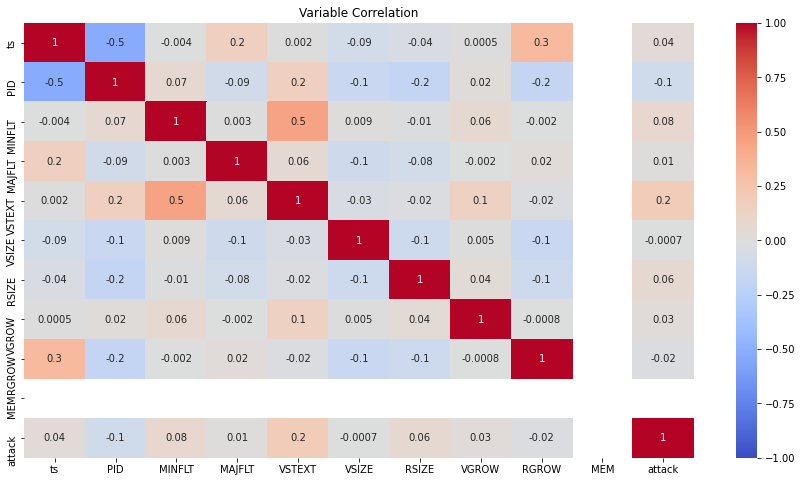

In [23]:
# Correlation heat map for memory data
import matplotlib.pyplot as plt
import seaborn as sns

memory = df_memory.toPandas()
plt.figure(figsize=(15,8))
sns.heatmap(memory.corr(), annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
plt.title("Memory Variable Correlation")

Text(0.5, 1.0, 'Variable Correlation')

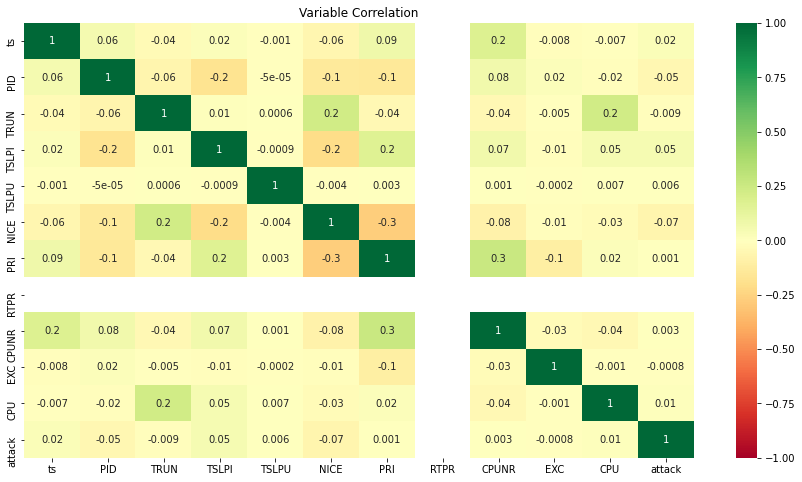

In [24]:
# Correlation heat map for process data
process = df_process.toPandas()
plt.figure(figsize=(15,8))
sns.heatmap(process.corr(), annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'RdYlGn')
plt.title("Process Variable Correlation")

### 2. Feature extraction and ML training

#### 2.1 Preparing the training data and testing data

In [25]:
# Splitting the process and memory data in 80-20
trainMemory, testMemory = df_memory.randomSplit([0.8, 0.2], seed=12345)
trainProcess, testProcess = df_process.randomSplit([0.8, 0.2], seed=12345)
print("Training Dataset Count Memory: " + str(trainMemory.count()))
print("Test Dataset Count Memory: " + str(testMemory.count()))
print("Training Dataset Count Process: " + str(trainProcess.count()))
print("Test Dataset Count Process: " + str(testProcess.count()))

Training Dataset Count Memory: 1600295
Test Dataset Count Memory: 399705
Training Dataset Count Process: 1542652
Test Dataset Count Process: 385316


In [26]:
# filtering out attack and non attack data for memory data
non_attack_memory_df = trainMemory.filter(col("attack") == 0)
attack_memory_df = trainMemory.filter(col("attack") == 1)
# filtering out attack and non attack data for process data
non_attack_process_df = trainProcess.filter(col("attack") == 0)
attack_process_df = trainProcess.filter(col("attack") == 1)

In [27]:
# extracting 20% attack labeled data
memory_attack20, _ = attack_memory_df.randomSplit([0.2,0.8], seed=12345)
# creating count limit for non attack data twice the attack data 
non_attack_count = memory_attack20.count()*2
# extracting non attack data
nonAttack_df = non_attack_memory_df.limit(non_attack_count)
# creating rebalanced data with 1:2 ration of attack and non attack
df_memory_rebalanced = nonAttack_df.union(memory_attack20)

In [28]:
# extracting 20% attack labeled data
process_attack20, _ = attack_process_df.randomSplit([0.2,0.8], seed=12345)
# creating count limit for non attack data twice the attack data 
non_attack_count = process_attack20.count()*2
# extracting non attack data
nonAttack_df = non_attack_process_df.limit(non_attack_count)
# creating rebalanced data with 1:2 ration of attack and non attack
df_process_rebalanced = nonAttack_df.union(process_attack20)

In [29]:
# taking count of attack label
df_memory_rebalanced.groupBy('attack').agg(F.count('attack')).show()
df_process_rebalanced.groupBy('attack').agg(F.count('attack')).show()

+------+-------------+
|attack|count(attack)|
+------+-------------+
|     1|        32955|
|     0|        65910|
+------+-------------+

+------+-------------+
|attack|count(attack)|
+------+-------------+
|     1|        46729|
|     0|        93458|
+------+-------------+



#### 2.2 Preparing features, labels and models

1. Based on data exploration from 1.3.3, which features would you select? Discuss the
reason for selecting them and how you plan to further transform them.<br>

A) For Process data, I have choose 'TSLPI', 'TSLPU', 'PRI', 'CPUNR', 'CPU' numeric fetaures and categoricla features 'POLI', 'Status', 'State', 'CMD' for models. Reason for choosing these variables is their correlation with attack label and correlation with other features.<br>
B) For Process data, I have choose 'MINFLT', 'MAJFLT', 'VSTEXT', 'RSIZE','VGROW' numeric fetaures and categoricla features 'CMD' for models. Reason for choosing these variables is their correlation with attack label and correlation with other features.<br>

**Transformation of features**<br>
For categorical features in both process and memory data, StringIndexer and  one-hot encoded is used. StringIndexer it indexes each categorical column, then converts the indexed categories into one-hot encoded variables. The resulting output has the binary vectors appended to the end of each row and VectorAssembler will combine all the feature columns (numeric and categorical) into a single vector column.

In [64]:
# print(numeric_features_memory)
# print(numeric_features_process)
# print(cat_features_memory)
# print(cat_features_process)

In [31]:
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier

#### Transformers / Estimators for transforming / assembling the features for Process data

2. Create Transformers / Estimators for transforming / assembling the features you
selected above in 2.2.1

In [32]:
# Creating Transformers / Estimators for transforming / assembling the features
CatCol_process = cat_features_process
NumCol_process = ['TSLPI', 'TSLPU', 'PRI', 'CPUNR', 'CPU']

# converting categorical data for pipline
stringIndexer_process = StringIndexer(inputCols=CatCol_process, outputCols=[x+"_index" for x in CatCol_process]).setHandleInvalid("keep")
# one hot encoder
OHE_process = stringIndexer_process.getOutputCols()
encoder_process = OneHotEncoder(inputCols = OHE_process, outputCols = [x+"_Vec" for x in OHE_process])
# assembling numeric and categorical features
inputCols_process = encoder_process.getOutputCols() + NumCol_process
assembler_process = VectorAssembler(inputCols = inputCols_process,outputCol='features')

#### Transformers / Estimators for transforming / assembling the features for Memory data

In [33]:
# for memory
CatCol_memory = ['CMD']
NumCol_memory = ['MINFLT', 'MAJFLT', 'VSTEXT', 'RSIZE','VGROW']
# converting categorical data for pipline
stringIndexer_memory = StringIndexer(inputCols=['CMD'], outputCols=['CMD'+'_index']).setHandleInvalid("keep")
# one hot encoder
OHE_memory = stringIndexer_memory.getOutputCols()
encoder_memory = OneHotEncoder(inputCols = OHE_memory, outputCols = [x+"_Vec" for x in OHE_memory])
# assembling numeric and categorical features
inputCols_memory = encoder_memory.getOutputCols() + NumCol_memory
assembler_memory = VectorAssembler(inputCols = inputCols_memory,outputCol='features').setHandleInvalid("keep")

3. Prepare Estimators for Decision Tree and Gradient Boosted Tree model for each use
case and include them into ML Pipelines for use case 1, 2

In [34]:
# Estimators for Decision Tree and Gradient Boosted Tree model for each use case 
# Process data
# Decision tree
dt_process = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'attack', maxDepth = 3)
# creating pipeline
pipeline_dt_process = Pipeline(stages = [stringIndexer_process, encoder_process,assembler_process,dt_process])

# Memory data
# Decision tree
dt_memory = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'attack', maxDepth = 3)
# creating pipeline
pipeline_dt_memory = Pipeline(stages = [stringIndexer_memory, encoder_memory, assembler_memory, dt_memory])


In [35]:
# Process data
# Gradient Boosted Tree
gbt_process = GBTClassifier(labelCol="attack", featuresCol="features", maxIter=3)
# creating pipeline
pipeline_gbt_process = Pipeline(stages = [stringIndexer_process, encoder_process,assembler_process,gbt_process])
# Memory data
# Gradient Boosted Tree 
gbt_memory = GBTClassifier(featuresCol = 'features', labelCol = 'attack', maxIter=3)
# creating pipeline
pipeline_gbt_memory = Pipeline(stages = [stringIndexer_memory, encoder_memory, assembler_memory, gbt_memory])


#### 2.3 Training and evaluating models

1. For each use case, use the corresponding ML Pipeline from previous step to train the
models on the rebalanced training data from 2.1.2

2. For each use case, test the models on the testing data from 2.1.1 and display the
count of each combination of attack label and prediction label in formats as below.

In [36]:
# traing data and predicting attack and non attack lable on test data for both mempry and process data using Decision tree
pipelineModel_dt_process = pipeline_dt_process.fit(df_process_rebalanced)
# prediction
df_process_dt_predict = pipelineModel_dt_process.transform(testProcess)

pipelineModel_dt_memory = pipeline_dt_memory.fit(df_memory_rebalanced)
# prediction
df_memory_dt_predict = pipelineModel_dt_memory.transform(testMemory)

In [37]:
# traing data and predicting attack and non attack lable on test data for both mempry and process data using Gradient Boosted Tree
pipelineModel_gbt_process = pipeline_gbt_process.fit(df_process_rebalanced)
df_process_gbt_predict = pipelineModel_gbt_process.transform(testProcess)

pipelineModel_gbt_memory = pipeline_gbt_memory.fit(df_memory_rebalanced)
df_memory_gbt_predict = pipelineModel_gbt_memory.transform(testMemory)

In [38]:
# count of each combination of attack label and prediction label for DT and GBT for process data
df_process_dt_predict.groupBy(['attack', 'prediction']).count().show()
df_process_gbt_predict.groupBy(['attack', 'prediction']).count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 21878|
|     0|       0.0|214668|
|     1|       1.0| 36245|
|     0|       1.0|112525|
+------+----------+------+

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 17742|
|     0|       0.0|197714|
|     1|       1.0| 40381|
|     0|       1.0|129479|
+------+----------+------+



#### AUC for Process data

In [39]:
evaluator = BinaryClassificationEvaluator(labelCol='attack')
# calculating Area under the curve for ROC
auroc_dt = evaluator.evaluate(df_process_dt_predict, {evaluator.metricName: "areaUnderROC"})
auroc_gbt = evaluator.evaluate(df_process_gbt_predict, {evaluator.metricName: "areaUnderROC"})

print("Area under ROC Curve for DT: {:.4f}".format(auroc_dt))
print("Area under ROC Curve for GBT: {:.4f}".format(auroc_gbt))

Area under ROC Curve for DT: 0.5983
Area under ROC Curve for GBT: 0.6787


In [40]:
# count of each combination of attack label and prediction label for DT and GBT for memory data
df_memory_dt_predict.groupBy(['attack', 'prediction']).count().show()
df_memory_gbt_predict.groupBy(['attack', 'prediction']).count().show()

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0|  2938|
|     0|       0.0| 76275|
|     1|       1.0| 38323|
|     0|       1.0|282169|
+------+----------+------+

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0|  2717|
|     0|       0.0| 74663|
|     1|       1.0| 38544|
|     0|       1.0|283781|
+------+----------+------+



#### AUC for Memory Data

In [41]:
evaluator = BinaryClassificationEvaluator(labelCol='attack')
# calculating Area under the curve for ROC
auroc_dt = evaluator.evaluate(df_memory_dt_predict, {evaluator.metricName: "areaUnderROC"})
auroc_gbt = evaluator.evaluate(df_memory_gbt_predict, {evaluator.metricName: "areaUnderROC"})

print("Area under ROC Curve for DT: {:.4f}".format(auroc_dt))
print("Area under ROC Curve for GBT: {:.4f}".format(auroc_gbt))

Area under ROC Curve for DT: 0.5644
Area under ROC Curve for GBT: 0.5688


3. Compute the AUC, accuracy, recall and precision for the attack label from each
model testing result using pyspark MLlib / ML APIs. Discuss which metric is more
proper for measuring the model performance on identifying attacks.

#### Computing AUC, accuracy, recall and precision for Process data

In [42]:
# Computing AUC, accuracy, recall and precision for Process data for Decision Tree
process_TN = df_process_dt_predict.filter('prediction = 0 AND attack = 0').count()
process_TP = df_process_dt_predict.filter('prediction = 1 AND attack = 1').count()
process_FN = df_process_dt_predict.filter('prediction = 1 AND attack = 0').count()
process_FP = df_process_dt_predict.filter('prediction = 0 AND attack = 1').count()

# Accuracy
Accuracy = (process_TN + process_TP)/(process_TN + process_TP + process_FN + process_FP)
print("Decision Tree Model Accuracy: ",Accuracy)

# Precision
if process_TP == 0:
    Precision = 1
else:
    Precision = process_TP/(process_TP+process_FP)
print("Decision Tree Model Precision: ", Precision)

# Recall
if  process_TP == 0:
    Recall = 1
else:
    Recall = process_TP/(process_TP+process_FN)
print("Decision Tree Model Recall: ", Recall)

Decision Tree Model Accuracy:  0.6511875966738988
Decision Tree Model Precision:  0.6235913493797636
Decision Tree Model Recall:  0.243631108422397


In [43]:
# Computing AUC, accuracy, recall and precision for Process data for Gradient Boosted Tree
process_TN = df_process_gbt_predict.filter('prediction = 0 AND attack = 0').count()
process_TP = df_process_gbt_predict.filter('prediction = 1 AND attack = 1').count()
process_FN = df_process_gbt_predict.filter('prediction = 1 AND attack = 0').count()
process_FP = df_process_gbt_predict.filter('prediction = 0 AND attack = 1').count()

# Accuracy
Accuracy = (process_TN+process_TP)/(process_TN+process_TP+process_FN+process_FP)
print("Gradient Boosted Tree Model Accuracy: ",Accuracy)

# Precision
if process_TP == 0:
    Precision = 1
else:
    Precision = process_TP/(process_TP+process_FP)
print("Gradient Boosted Tree Model Precision: ", Precision)

# Recall
if  process_TP == 0:
    Recall = 1
else:
    Recall = process_TP/(process_TP+process_FN)
print("Gradient Boosted Tree Model Recall: ", Recall)

Gradient Boosted Tree Model Accuracy:  0.6179213943879829
Gradient Boosted Tree Model Precision:  0.6947507871238581
Gradient Boosted Tree Model Recall:  0.23773107264806312


#### Computing AUC, accuracy, recall and precision for Memory data

In [44]:
# for memory
memory_TN = df_memory_dt_predict.filter('prediction = 0 AND attack = 0').count()
memory_TP = df_memory_dt_predict.filter('prediction = 1 AND attack = 1').count()
memory_FN = df_memory_dt_predict.filter('prediction = 1 AND attack = 0').count()
memory_FP = df_memory_dt_predict.filter('prediction = 0 AND attack = 1').count()

# Accuracy
Accuracy = (memory_TN + memory_TP)/(memory_TN + memory_TP + memory_FN + memory_FP)
print("Decision Tree Model Accuracy: ",Accuracy)

# Precision
if memory_TP == 0:
    Precision = 1
else:
    Precision = memory_TP/(memory_TP+memory_FP)
print("Decision Tree Model Precision: ", Precision)

# Recall
if  memory_TP == 0:
    Recall = 1
else:
    Recall = memory_TP/(memory_TP+memory_FN)
print("Decision Tree Model Recall: ", Recall)

Decision Tree Model Accuracy:  0.2867064460039279
Decision Tree Model Precision:  0.928794745643586
Decision Tree Model Recall:  0.1195755276262746


In [45]:
# for memory
memory_TN = df_memory_gbt_predict.filter('prediction = 0 AND attack = 0').count()
memory_TP = df_memory_gbt_predict.filter('prediction = 1 AND attack = 1').count()
memory_FN = df_memory_gbt_predict.filter('prediction = 1 AND attack = 0').count()
memory_FP = df_memory_gbt_predict.filter('prediction = 0 AND attack = 1').count()

# Accuracy
Accuracy = (memory_TN+memory_TP)/(memory_TN+memory_TP+memory_FN+memory_FP)
print("Gradient Boosted Tree Model Accuracy: ",Accuracy)

# Precision
if memory_TP == 0:
    Precision = 1
else:
    Precision = memory_TP/(memory_TP+memory_FP)
print("Gradient Boosted Tree Model Precision: ", Precision)

# Recall
if  memory_TP == 0:
    Recall = 1
else:
    Recall = memory_TP/(memory_TP+memory_FN)
print("Gradient Boosted Tree Model Recall: ", Recall)

Gradient Boosted Tree Model Accuracy:  0.28322637945484797
Gradient Boosted Tree Model Precision:  0.9341508930951746
Gradient Boosted Tree Model Recall:  0.11958116807569999


#### Discuss which metric is more proper for measuring the model performance on identifying attacks.<br>

**Precision metric is more proper for measuring the model performance on identifying attacks. Accuracy is better when we have symmetric datasets where values of false positive and false negatives are almost same. But Precision metric answer is of all attack that labeled as 0 or 1, how many actually are 0 or 1**<br>
**Other than this AUC is also best metric to measure model performace as higher the AUC, better is the model.**

4. Display the top-5 most important features in each model. Discuss which pipeline
model is better, and whether the feature “ts” should be included in the model6. And
visualise the ROC curve for the better model you selected for each use case.<br>

Memory top features, 'MINFLT', 'MAJFLT', 'VSTEXT', 'RSIZE','VGROW'<br>
Process top features 'TSLPI', 'TSLPU', 'PRI', 'CPUNR', 'CPU'<br>

For both Process and Memory data, Gradient Boosted Tree is the best model as it's provide higher AUC and Precision. For memory, GBT gave precision of 0.93 and 0.69 for process. If we talk about AUC, GBT has 0.56 AUC and 0.67 AUC for memory and process repectively.<br>

**whether the feature “ts” should be included in the model?**<br>
I have not included "ts" in the model. Reason being that ts represent time stamp of the data. As stated in the description of the project, they are a subset of the Internet of Things dataset. So, mostly data is collected through sensors or other devices and on timely basis. Thus timestamp only only present when the data was recored. Including the timestamp in my opinion is not useful.



#### ROC for Memory Data Prediction

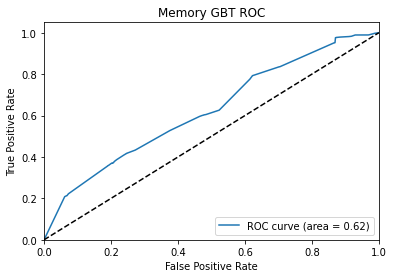

In [65]:
# https://weiminwang.blog/2016/06/09/pyspark-tutorial-building-a-random-forest-binary-classifier-on-unbalanced-dataset/
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = df_memory_gbt_predict.select(['probability', 'attack'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]

from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Memory GBT ROC')
plt.legend(loc="lower right")
plt.show()

#### ROC for Process Data Prediction

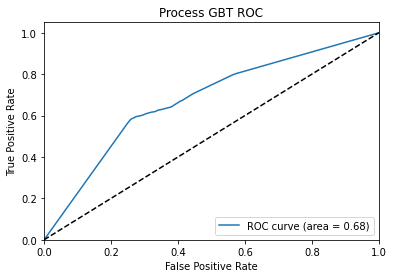

In [66]:
# https://weiminwang.blog/2016/06/09/pyspark-tutorial-building-a-random-forest-binary-classifier-on-unbalanced-dataset/

results = df_process_gbt_predict.select(['probability', 'attack'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]

from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Process GBT ROC')
plt.legend(loc="lower right")
plt.show()

5. Using the pipeline model you selected in the previous step, re-train the pipeline
model using a bigger set of rebalanced training data, with attack events and
non-attack events being 1:2 ratio, while using all attack events data from the full data
for both use cases. Then persist the better models for each use case.<br>

For both Process and Memory data, Gradient Boosted Tree is the best model as it's provide higher AUC. If we talk about AUC, GBT has 0.62 AUC and 0.67 AUC for memory and process repectively. All the steps are done below.

In [48]:
# filtering attack and non attack label
non_attack_memory_df = df_memory.filter(col("attack") == 0)
attack_memory_df = df_memory.filter(col("attack") == 1)

non_attack_process_df = df_process.filter(col("attack") == 0)
attack_process_df = df_process.filter(col("attack") == 1)

In [49]:
# creating count limit for non attack data twice the attack data
non_attack_count = attack_memory_df.count()*2
# extracting non attack data
nonAttack_df = non_attack_memory_df.limit(non_attack_count)
# creating full data with 1:2 ration of attack and non attack
df_memory_full= nonAttack_df.unionAll(memory_attack20)

In [50]:
# creating count limit for non attack data twice the attack data
non_attack_count = attack_process_df.count()*2
# extracting non attack data
nonAttack_df = non_attack_process_df.limit(non_attack_count)
# creating full data with 1:2 ration of attack and non attack
df_process_full = nonAttack_df.union(process_attack20)

In [51]:
# count of each combination of attack label and prediction label for DT and GBT for process data
df_memory_full.groupBy('attack').agg(F.count('attack')).show()
df_process_full.groupBy('attack').agg(F.count('attack')).show()

+------+-------------+
|attack|count(attack)|
+------+-------------+
|     1|        32955|
|     0|       411246|
+------+-------------+

+------+-------------+
|attack|count(attack)|
+------+-------------+
|     1|        46729|
|     0|       582728|
+------+-------------+



#### Prediction for Memory Data using full data

In [52]:
# Estimators for Decision Tree and Gradient Boosted Tree model for each use case
dt_memory = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'attack', maxDepth = 3)
# pipeline
pipeline_dt_memory = Pipeline(stages = [stringIndexer_memory, encoder_memory, assembler_memory, dt_memory])
# fit train data
pipelineModel_dt_memory = pipeline_dt_memory.fit(df_memory_full)
# prediction
df_memory_dt_predict = pipelineModel_dt_memory.transform(testMemory)

In [53]:
# Estimators for Decision Tree and Gradient Boosted Tree model for each use case
gbt_memory = GBTClassifier(featuresCol = 'features', labelCol = 'attack', maxIter=3)
# pipeline
pipeline_gbt_memory = Pipeline(stages = [stringIndexer_memory, encoder_memory, assembler_memory, gbt_memory])
# fit train data
pipelineModel_gbt_memory = pipeline_gbt_memory.fit(df_memory_full)
# prediction
df_memory_gbt_predict = pipelineModel_gbt_memory.transform(testMemory)

#### Prediction for Process Data full data

In [54]:
# Estimators for Decision Tree and Gradient Boosted Tree model for each use case
dt_process = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'attack', maxDepth = 3)
# pipeline
pipeline_dt_process = Pipeline(stages = [stringIndexer_process, encoder_process,assembler_process,dt_process])
# fit train data
pipelineModel_dt_process = pipeline_dt_process.fit(df_process_full)
# prediction
df_process_dt_predict = pipelineModel_dt_process.transform(testProcess)

In [55]:
# Estimators for Decision Tree and Gradient Boosted Tree model for each use case
gbt_process = GBTClassifier(labelCol="attack", featuresCol="features", maxIter=3)
# pipeline
pipeline_gbt_process = Pipeline(stages = [stringIndexer_process, encoder_process,assembler_process,gbt_process])
# fit train data
pipelineModel_gbt_process = pipeline_gbt_process.fit(df_process_full)
# prediction
df_process_gbt_predict = pipelineModel_gbt_process.transform(testProcess)

#### Then persist the better models for each use case.

In [56]:
# count of each combination of attack label and prediction label for DT and GBT for process data
df_process_dt_predict.groupBy(['attack', 'prediction']).count().show()
df_process_gbt_predict.groupBy(['attack', 'prediction']).count().show()

evaluator = BinaryClassificationEvaluator(labelCol='attack')
# calculating Area under the curve for ROC
auroc_dt = evaluator.evaluate(df_process_dt_predict, {evaluator.metricName: "areaUnderROC"})
auroc_gbt = evaluator.evaluate(df_process_gbt_predict, {evaluator.metricName: "areaUnderROC"})

print("Area under ROC Curve for DT: {:.4f}".format(auroc_dt))
print("Area under ROC Curve for GBT: {:.4f}".format(auroc_gbt))

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 23831|
|     0|       0.0|219440|
|     1|       1.0| 34292|
|     0|       1.0|107753|
+------+----------+------+

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 20206|
|     0|       0.0|205477|
|     1|       1.0| 37917|
|     0|       1.0|121716|
+------+----------+------+

Area under ROC Curve for DT: 0.5839
Area under ROC Curve for GBT: 0.6752


In [57]:
# count of each combination of attack label and prediction label for DT and GBT for process data
df_memory_dt_predict.groupBy(['attack', 'prediction']).count().show()
df_memory_gbt_predict.groupBy(['attack', 'prediction']).count().show()

evaluator = BinaryClassificationEvaluator(labelCol='attack')
# calculating Area under the curve for ROC
auroc_dt = evaluator.evaluate(df_memory_dt_predict, {evaluator.metricName: "areaUnderROC"})
auroc_gbt = evaluator.evaluate(df_memory_gbt_predict, {evaluator.metricName: "areaUnderROC"})

print("Area under ROC Curve for DT: {:.4f}".format(auroc_dt))
print("Area under ROC Curve for GBT: {:.4f}".format(auroc_gbt))

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 40716|
|     0|       0.0|349021|
|     1|       1.0|   545|
|     0|       1.0|  9423|
+------+----------+------+

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 36097|
|     0|       0.0|350370|
|     1|       1.0|  5164|
|     0|       1.0|  8074|
+------+----------+------+

Area under ROC Curve for DT: 0.5547
Area under ROC Curve for GBT: 0.6244


#### AUC, accuracy, recall and precision

In [58]:
# for process
process_TN = df_process_dt_predict.filter('prediction = 0 AND attack = 0').count()
process_TP = df_process_dt_predict.filter('prediction = 1 AND attack = 1').count()
process_FN = df_process_dt_predict.filter('prediction = 1 AND attack = 0').count()
process_FP = df_process_dt_predict.filter('prediction = 0 AND attack = 1').count()

# Accuracy
Accuracy = (process_TN+process_TP)/(process_TN+process_TP+process_FN+process_FP)
print("Decision Tree Model Accuracy: ",Accuracy)

# Precision
if process_TP == 0:
    Precision = 1
else:
    Precision = process_TP/(process_TP+process_FP)
print("Decision Tree Model Precision: ", Precision)

# Recall
if  process_TP == 0:
    Recall = 1
else:
    Recall = process_TP/(process_TP+process_FN)
print("Decision Tree Model Recall: ", Recall)

# for process
process_TN = df_process_gbt_predict.filter('prediction = 0 AND attack = 0').count()
process_TP = df_process_gbt_predict.filter('prediction = 1 AND attack = 1').count()
process_FN = df_process_gbt_predict.filter('prediction = 1 AND attack = 0').count()
process_FP = df_process_gbt_predict.filter('prediction = 0 AND attack = 1').count()

# Accuracy
Accuracy = (process_TN+process_TP)/(process_TN+process_TP+process_FN+process_FP)
print("Gradient Boosted Tree Model Accuracy: ",Accuracy)

# Precision
if process_TP == 0:
    Precision = 1
else:
    Precision = process_TP/(process_TP+process_FP)
print("Gradient Boosted Tree Model Precision: ", Precision)

# Recall
if  process_TP == 0:
    Recall = 1
else:
    Recall = process_TP/(process_TP+process_FN)
print("Gradient Boosted Tree Model Recall: ", Recall)

Decision Tree Model Accuracy:  0.6585036697152467
Decision Tree Model Precision:  0.5899901932109491
Decision Tree Model Recall:  0.2414164525326481
Gradient Boosted Tree Model Accuracy:  0.6316737431095516
Gradient Boosted Tree Model Precision:  0.6523579305954613
Gradient Boosted Tree Model Recall:  0.23752607543553025


In [59]:
# for memory
memory_TN = df_memory_dt_predict.filter('prediction = 0 AND attack = 0').count()
memory_TP = df_memory_dt_predict.filter('prediction = 1 AND attack = 1').count()
memory_FN = df_memory_dt_predict.filter('prediction = 1 AND attack = 0').count()
memory_FP = df_memory_dt_predict.filter('prediction = 0 AND attack = 1').count()

# Accuracy
Accuracy = (memory_TN+memory_TP)/(memory_TN+memory_TP+memory_FN+memory_FP)
print("Decision Tree Model Accuracy: ",Accuracy)

# Precision
if memory_TP == 0:
    Precision = 1
else:
    Precision = memory_TP/(memory_TP+memory_FP)
print("Decision Tree Model Precision: ", Precision)

# Recall
if  memory_TP == 0:
    Recall = 1
else:
    Recall = memory_TP/(memory_TP+memory_FN)
print("Decision Tree Model Recall: ", Recall)

# for memory
memory_TN = df_memory_gbt_predict.filter('prediction = 0 AND attack = 0').count()
memory_TP = df_memory_gbt_predict.filter('prediction = 1 AND attack = 1').count()
memory_FN = df_memory_gbt_predict.filter('prediction = 1 AND attack = 0').count()
memory_FP = df_memory_gbt_predict.filter('prediction = 0 AND attack = 1').count()

# Accuracy
Accuracy = (memory_TN+memory_TP)/(memory_TN+memory_TP+memory_FN+memory_FP)
print("Gradient Boosted Tree Model Accuracy: ",Accuracy)

# Precision
if memory_TP == 0:
    Precision = 1
else:
    Precision = memory_TP/(memory_TP+memory_FP)
print("Gradient Boosted Tree Model Precision: ", Precision)

# Recall
if  memory_TP == 0:
    Recall = 1
else:
    Recall = memory_TP/(memory_TP+memory_FN)
print("Gradient Boosted Tree Model Recall: ", Recall)

Decision Tree Model Accuracy:  0.8745599879911434
Decision Tree Model Precision:  0.013208598919076124
Decision Tree Model Recall:  0.05467495987158909
Gradient Boosted Tree Model Accuracy:  0.889490999612214
Gradient Boosted Tree Model Precision:  0.1251545042534112
Gradient Boosted Tree Model Recall:  0.39008913733192324


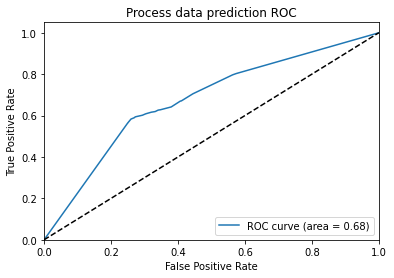

In [60]:
# https://weiminwang.blog/2016/06/09/pyspark-tutorial-building-a-random-forest-binary-classifier-on-unbalanced-dataset/

results = df_process_gbt_predict.select(['probability', 'attack'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]

from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Process data prediction ROC')
plt.legend(loc="lower right")
plt.show()

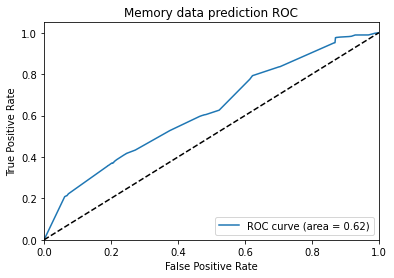

In [61]:
# https://weiminwang.blog/2016/06/09/pyspark-tutorial-building-a-random-forest-binary-classifier-on-unbalanced-dataset/

results = df_memory_gbt_predict.select(['probability', 'attack'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]

from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Memory data prediction ROC')
plt.legend(loc="lower right")
plt.show()

### 3. Knowledge sharing

3.1 How many jobs are observed when training the KMeans clustering model following the code below? Provide a screenshot from Spark UI for running a simple KMeans model training.

In [62]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
iris_df = spark.createDataFrame([
(4.7, 3.2, 1.3, 0.2),
(4.9, 3.1, 1.5, 0.1),
(5.4, 3.9, 1.3, 0.4),
(5.0, 3.4, 1.6, 0.4),
(5.1, 3.8, 1.6, 0.2),
(4.9, 2.4, 3.3, 1.0),
(6.6, 2.9, 4.6, 1.3),
(5.6, 3.0, 4.5, 1.5),
(5.7, 2.6, 3.5, 1.0),
(5.8, 2.6, 4.0, 1.2),
(5.8, 2.8, 5.1, 2.4),
(6.2, 2.8, 4.8, 1.8),
(6.0, 3.0, 4.8, 1.8),
(6.7, 3.1, 5.6, 2.4),
(6.7, 3.0, 5.2, 2.3),
(6.2, 3.4, 5.4, 2.3)],
['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
assembler = VectorAssembler(
inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
outputCol='features')

kmeans = KMeans(k=3).fit(assembler.transform(iris_df))

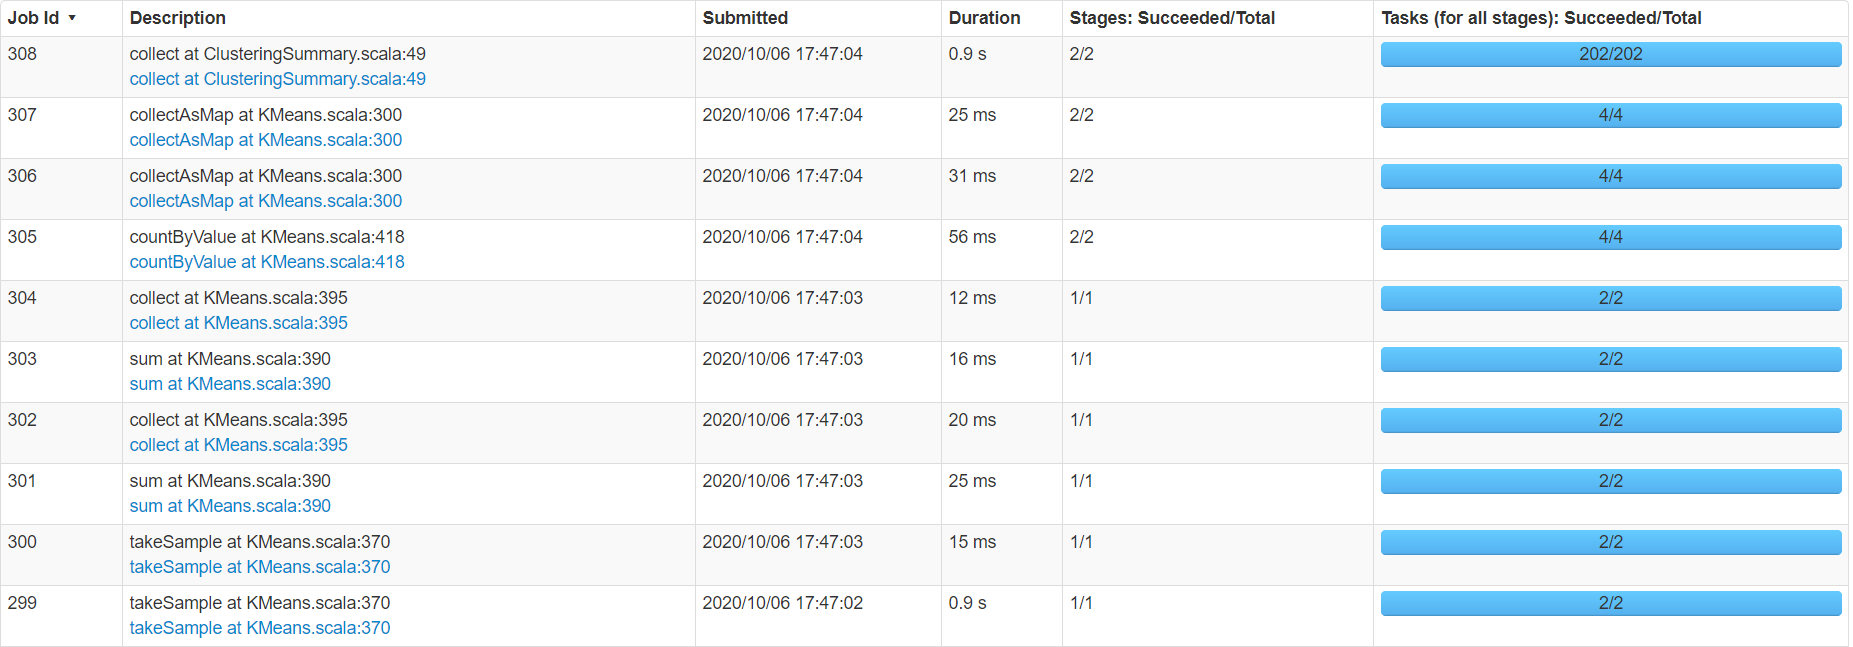

I have observed total 10 jobs when training the KMeans clustering model.

3.2 Combining the KMeans algorithm from the lecture, explain what each job in Spark UI
represents

1) takeSample at KMeans.scala:370 -> It initializes the cluster center and then takes the sample of dataset. Parallize the data to work with pyspark.<br>
2) sum at KMeans.scala:390 -> Then it compute distance between center and points in each iteration<br>
3) collect at KMeans.scala:395 -> Again collect the data for calculation and transformation.<br>
4) collectAsMap at KMeans.scala:300 ->  Arrange and calculate cluster weight. Reduces by key, and countByValue at KMeans.scala:418 - Their might be distinict K. It weights k by the no. of points in the dataset mapped to it.<br>
5) collect at ClusteringSummary.scala:49 -> As per cost, zip the data. Result is collected after filtering out the point cost.
